<span style="color:red; font-size:22pt">
Importing necessary libraries
</span>  

In [11]:

# 1. `pandas`: Used for data manipulation and analysis. It provides convenient data structures and functions to work with structured data, 
# such as DataFrames, which can be useful for organizing and preprocessing textual data before topic modeling.

# 2. `re`: It is used for pattern matching and text manipulation tasks, such as removing URLs or special characters.

# 3. `gensim`: It provides functions from `gensim` for building the LDA model, preprocessing text, and calculating topic coherence.

# 4. `corpora` (from `gensim`): offers functionality for creating, loading, and saving document collections in different formats.

# 5. `simple_preprocess` (from `gensim.utils`): for performing simple preprocessing tasks such as lowercasing, tokenizing, and removing stopwords.

# 6. `CoherenceModel` (from `gensim.models`): A class in `gensim` for computing topic coherence scores.

# 7. `spacy`: It provides tools and models for part-of-speech tagging, entity recognition, and lemmatization.

# 8. `matplotlib.pyplot` (imported as `plt`): In topic modeling, it can be used to visualize the results, 
# such as topic-word distributions or coherence scores.

# 9. `WordCloud` (from `wordcloud`): A library for generating word clouds, which visually represent the 
# most frequent words in a text corpus. It is often used to visualize the most important terms associated with each topic in topic modeling.

# 10. `stopwords` (from `nltk.corpus`): These are words that are considered insignificant 
# in the context of text analysis, such as "and," "the," or "is."

import pandas as pd
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


<span style="color:red; font-size:22pt">
Loading Dataset - can be found in the link- <a href="https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews"> amazon reviews (press here)</a>, used train.csv file for this project
</span>  

In [12]:

# Load the dataset - 28sec
df = pd.read_csv(r'D:\Education\University\Multi Modal Data Analysis\Project\Dataset samples\amazon_review_polarity_csv\train.csv')


<span style="color:red; font-size:22pt">
considered only 1,00,000 rows of data
</span>  

In [13]:

df_new = df.head(100000)
df_new.columns = ['Sentiment Score', 'Head', 'Body']


In [14]:
df_new

,Sentiment Score,Head,Body
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...
...,...,...,...
99995,1,THE REAL SUPERMAN,THESE ARE THE REAL ADVENTURES OF THE REAL SUPE...
99996,1,It gets one star because zero was not an optio...,Sylvain Beauregard is WIDELY known to die-hard...
99997,1,Don't Spend Your Money,I think I now know more about the person who w...
99998,1,Enough already,"This is what you call ""overkill."" How many boo..."


<span style="color:red; font-size:22pt">
Considering only body column of the data
</span> 

In [15]:

# Preprocess the data
data = df_new.Body.values.tolist()
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("'", '', sent) for sent in data]


In [30]:

# Remove stopwords - 21sec for 1lakh
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words = remove_stopwords(data)


<span style="color:red; font-size:22pt">
Tokenization
</span> 

In [17]:

# Tokenization - 14sec for 1 lakh
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data_words))


<span style="color:red; font-size:22pt">
Bigrams and Trigrams
</span> 

In [18]:

# Build bigram and trigram models - 17sec for 1 lakh
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [19]:

# Form Bigrams
data_words_bigrams = [bigram_mod[doc] for doc in data_words]
data_words_trigrams = [trigram_mod[bigram_mod[doc]] for doc in data_words_bigrams]


<span style="color:red; font-size:22pt">
Lemmatization
</span> 

In [20]:

# Lemmatization - 10m for 1 lakh
nlp = spacy.load('en_core_web_sm')
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


<span style="color:red; font-size:22pt">
Word Cloud
</span> 

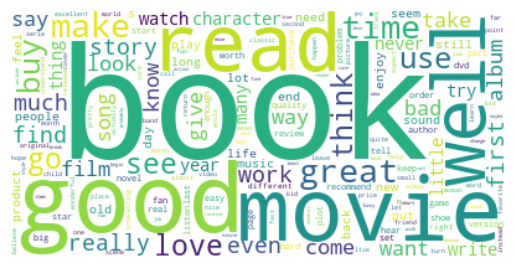

In [21]:


# Generate and display a word cloud
word_list = [word for sublist in data_lemmatized for word in sublist]
text = ' '.join(word_list)
word_cloud2 = WordCloud(collocations=False, background_color='white').generate(text)
plt.imshow(word_cloud2, interpolation='bilinear')
plt.axis("off")
plt.show()


<span style="color: red; font-size:22pt">creating a dictionary to map tokens to unique IDs and creating a corpus in the bag-of-words format, which is a numerical representation of the documents that can be used as input for LDA model.
</span>

In [22]:


# Create dictionary and corpus
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]



<span style="color:red; font-size:22pt">
LDA model building 
</span> 

In [23]:

# Build LDA model - 150min. 1lakh, 100 rs, cs 50, pass 100,
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=100, 
                                           update_every=1,
                                           chunksize=50, # prev 100
                                           passes=100,  # prev 10
                                           alpha='auto',
                                           per_word_topics=True)

#chunksize controls how many documents are processed at a time in the training algorithm. 
#Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
#passes controls how often we train the model on the entire corpus (set to 10). 
#Another word for passes might be “epochs”. 
#Iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. 
#It is important to set the number of “passes” and “iterations” high enough.

# Print the topics
from pprint import pprint
pprint(lda_model.print_topics())

# Further analysis of the topics as needed
doc_lda = lda_model[corpus]


[(0,
  '0.078*"product" + 0.051*"purchase" + 0.037*"order" + 0.028*"month" + '
  '0.022*"receive" + 0.021*"week" + 0.020*"send" + 0.019*"wrong" + '
  '0.019*"card" + 0.014*"shoe"'),
 (1,
  '0.041*"song" + 0.040*"album" + 0.030*"music" + 0.028*"sound" + 0.022*"hear" '
  '+ 0.019*"fan" + 0.018*"version" + 0.018*"listen" + 0.015*"track" + '
  '0.014*"favorite"'),
 (2,
  '0.050*"bad" + 0.038*"people" + 0.036*"ever" + 0.032*"s" + 0.025*"star" + '
  '0.024*"part" + 0.024*"live" + 0.015*"job" + 0.015*"copy" + 0.014*"full"'),
 (3,
  '0.029*"learn" + 0.026*"series" + 0.026*"style" + 0.021*"stuff" + '
  '0.020*"piece" + 0.019*"rather" + 0.018*"name" + 0.017*"person" + '
  '0.016*"collection" + 0.016*"description"'),
 (4,
  '0.034*"buy" + 0.033*"use" + 0.032*"well" + 0.032*"work" + 0.019*"look" + '
  '0.017*"try" + 0.016*"come" + 0.016*"many" + 0.015*"need" + 0.013*"put"'),
 (5,
  '0.089*"book" + 0.042*"read" + 0.018*"find" + 0.018*"story" + 0.014*"write" '
  '+ 0.014*"character" + 0.011*"end" + 

<span style="color:red; font-size:18pt"> we can estimate from the above topics that <br> topic 0 refers to Consummer goods,<br> topic 1 refers to music,<br> topic 2 refers to Negative experience,<br> topic 3 refers to Miscellanious,<br> topic 4 refers to General usage,<br> topic 5 refers to Literature,<br> topic 6 refers to Positive Experience,<br> topic 7 refers to Entertainment.
</span>

<span style="color:red ; font-size:22pt">
Identifying Dominant Topics
</span>

Topic 6: 44625 documents
Topic 5: 36710 documents
Topic 4: 16702 documents
Topic 1: 1782 documents
Topic 0: 122 documents
Topic 7: 34 documents
Topic 2: 20 documents
Topic 3: 5 documents


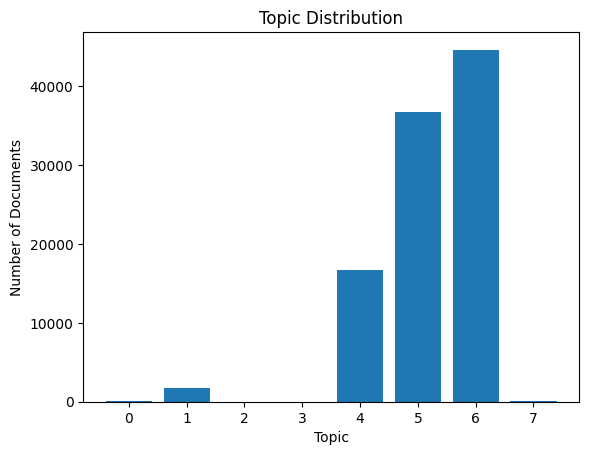

In [24]:

doc_lda = [lda_model.get_document_topics(doc) for doc in corpus]
# Identify dominant topics
dominant_topics = [max(topic, key=lambda item: item[1])[0] for topic in doc_lda]

# Count the occurrences of each dominant topic
topic_counts = {topic: dominant_topics.count(topic) for topic in dominant_topics}

# Sort the topics based on their counts in descending order
sorted_topics = sorted(topic_counts.items(), key=lambda item: item[1], reverse=True)

# Print the dominant topics and their counts
for topic, count in sorted_topics:
    print(f"Topic {topic}: {count} documents")

# Visualize topic distribution
topics, counts = zip(*sorted_topics)

plt.bar(topics, counts)
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution')
plt.show()



<span style="color:red; font-size:22pt">The above output prints topic number and number of documents it is dominated in. Below we will choose a topic and print out the documents in which the topic is dominant.</span>


In [25]:
# Choose a topic
chosen_topic = 2  # Change this value to the index of the desired topic

total = 0
# Print documents belonging to the chosen topic
for index, document in enumerate(data_lemmatized):
    doc_topics = lda_model.get_document_topics(corpus[index])
    dominant_topic = max(doc_topics, key=lambda item: item[1])[0]
    
    if dominant_topic == chosen_topic:
        #print(f"Document {index + 1}: {document}")
        # print(f"Document {index + 1}: ")
        # print(data[index])
        print(f"Document {index + 1}: {data[index]}")
        total = total + 1

print("total = " + str(total))

Document 22: Rather than scratches and insect droppings, this one has random pixelations combined with muddy light and vague image resolution. Probably the cue should have been the packaging is straight out of your street corner bootleg dealer.If youve ever seen a reasonably good condition film copy, you know the defining visuals of his film are the crystal clear lighting contrasts in black and white. The surrounding countryside and old home scenes are set with early morning ground mists or the haze of memory while the events on the bridge and in the water are bright, clear, and immediate.Here everything is dull, dark, and clouded. Or, if you remember the timbre and enunciation of Captains commands, so are the visuals.After that, it is hard to believe this award winning, critically acclaimed films best presentation is on YOUTUBE. Somewhere "out there" is a DVD that comes up to the standard of a 16mm public library reel.Just none of them appear to be on Amazon.
Document 1356: This is on

<span style="color:red; font-size:22pt">
Topic 2 is chosen and it is dominant in 20 dcouments. All the 20 documents are printed above with total count at the end.
</span> 

In [26]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.43120893241583

Coherence Score:  0.46693764308248253


In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

<span style="color:red; font-size:22pt">
Visualization using pyLDAvis
</span> 

In [29]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.149736  0.408197       1        1  25.633250
5     -0.278020 -0.063203       2        1  25.017422
4     -0.244741 -0.238970       3        1  19.564439
1      0.058462 -0.014161       4        1   8.492421
2      0.148774 -0.008478       5        1   7.116427
7      0.158391 -0.017726       6        1   5.955198
3      0.157881 -0.028850       7        1   4.127638
0      0.148989 -0.036809       8        1   4.093205, topic_info=             Term          Freq         Total Category  logprob  loglift
171          book  69320.000000  69320.000000  Default  30.0000  30.0000
9            good  34206.000000  34206.000000  Default  29.0000  29.0000
18           read  32561.000000  32561.000000  Default  28.0000  28.0000
241           get  28685.000000  28685.000000  Default  27.0000  27.0000
2             buy  21068.000000  21068.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1049         foot    890.495781    891.446882   Topic8  -4.9664   3.1948
1242       bother    886.482505    887.434051   Topic8  -4.9709   3.1948
821        seller    880.917188    881.867476   Topic8  -4.9772   3.1948
972       contact    871.250348    872.201203   Topic8  -4.9882   3.1948
1726  replacement    834.207445    835.157542   Topic8  -5.0317   3.1947

[289 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
739       6  0.999482      act
6120      8  0.998961  adapter
825       4  0.999888    album
930       3  0.999668   almost
263       1  0.675633     also
...     ...       ...      ...
28        2  0.999894    write
290       4  0.999285   writer
1045      7  0.999434  writing
1339      8  0.999690    wrong
30        1  0.999936     year

[273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 5, 2, 3, 8, 4, 1])